In [1]:
import csv
import itertools
import pathlib
import shutil
from math import ceil, sqrt
from pathlib import Path
from typing import Callable, List, Optional, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import rootutils
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from ipywidgets import Video
from skimage.metrics import structural_similarity
from sklearn.model_selection import GroupShuffleSplit
from torch import Tensor
from torch.utils.data import ConcatDataset, Dataset
from torchvision.io import read_image
from tqdm.notebook import tqdm

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png')

root = rootutils.setup_root(search_from=".", indicator=".project-root", pythonpath=True)

from src.data.components.dataset import (
    FetalBrainPlanesDataset,
    USVideosDataset,
    USVideosFrameDataset,
    VideoQualityDataset,
    VideosFrameDataset,
)
from src.data.components.transforms import Affine, HorizontalFlip, VerticalFlip
from src.data.utils.utils import show_numpy_images, show_pytorch_images
from src.models.fetal_module import FetalLitModule
from src.models.quality_module import QualityLitModule

path = root / "data" / "US_VIDEOS_tran_0500"
root

PosixPath('/home/zamojskia/ultrasound_fetal_images')

In [ ]:
# shutil.rmtree(path / "selected", ignore_errors=True)
# shutil.rmtree(path / "labeled", ignore_errors=True)

In [2]:
checkpoint_file = root / "logs" / "train" / "multiruns" / "2023-11-07_21-10-40" / "0"  # frosty-forest-2691

checkpoint = sorted(checkpoint_file.glob("checkpoints/epoch_*.ckpt"))[-1]
model = FetalLitModule.load_from_checkpoint(str(checkpoint))
# disable randomness, dropout, etc...
model.eval()

model.hparams.net_spec.name

'efficientnet_v2_m'

In [3]:
def label_video(video_path: Path):
    video_dense = []
    video_logits = []
    video_y_hats = []

    vidcap = cv2.VideoCapture(str(video_path))
    for frame in _frame_iter(vidcap, "Label frames"):
        frame = PIL.Image.fromarray(frame)
        frame = TF.to_tensor(frame)
        frame = frame.to(model.device)

        batch_size = 128
        batches = ceil(len(transforms) / batch_size)
        batch_dense = []
        batch_logits = []
        batch_y_hats = []
        for i in range(batches):
            batch_transforms = transforms[i * batch_size : (i + 1) * batch_size]
            frames = torch.stack([transform(frame) for transform in batch_transforms])

            with torch.no_grad():
                dense, logits = model(frames)
                y_hats = F.softmax(logits, dim=1)

            batch_dense.append(dense.cpu())
            batch_logits.append(logits.cpu())
            batch_y_hats.append(y_hats.cpu())

        video_dense.append(torch.cat(batch_dense, dim=0))
        video_logits.append(torch.cat(batch_logits, dim=0))
        video_y_hats.append(torch.cat(batch_y_hats, dim=0))

    return torch.stack(video_dense, dim=1), torch.stack(video_logits, dim=1), torch.stack(video_y_hats, dim=1)


def _frame_iter(capture, description):
    def iterator():
        while capture.grab():
            yield capture.retrieve()[1]

    return tqdm(
        iterator(),
        desc=description,
        total=int(capture.get(cv2.CAP_PROP_FRAME_COUNT)),
        position=0,
        leave=False,
    )


def lable_transform_video(video_path, horizontal_flips, vertical_flips, rotate_degrees, translates, scales):
    global transforms

    transforms = [
        T.Compose(
            [
                T.Grayscale(),
                T.Resize((165, 240), antialias=False),
                HorizontalFlip(flip=horizontal_flip),
                VerticalFlip(flip=vertical_flip),
                Affine(degrees=rotate_degree, translate=translate, scale=scale),
                T.ConvertImageDtype(torch.float32),
            ]
        )
        for horizontal_flip, vertical_flip, rotate_degree, translate, scale in itertools.product(
            horizontal_flips, vertical_flips, rotate_degrees, translates, scales
        )
    ]

    return label_video(video_path)


# device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
device = "cuda"
model.to(device)
video_path = sorted((path / "videos" / "train").iterdir())[0]
print(video_path.stem)

_, logits, y_hats = lable_transform_video(
    video_path=video_path,
    horizontal_flips=[False],
    vertical_flips=[False],
    rotate_degrees=[0],
    translates=[(0.0, 0.0)],
    scales=[1.0],
)

y_hats.shape

IMG_20211021_2_12


Label frames:   0%|          | 0/392 [00:00<?, ?it/s]

torch.Size([1, 392, 5])

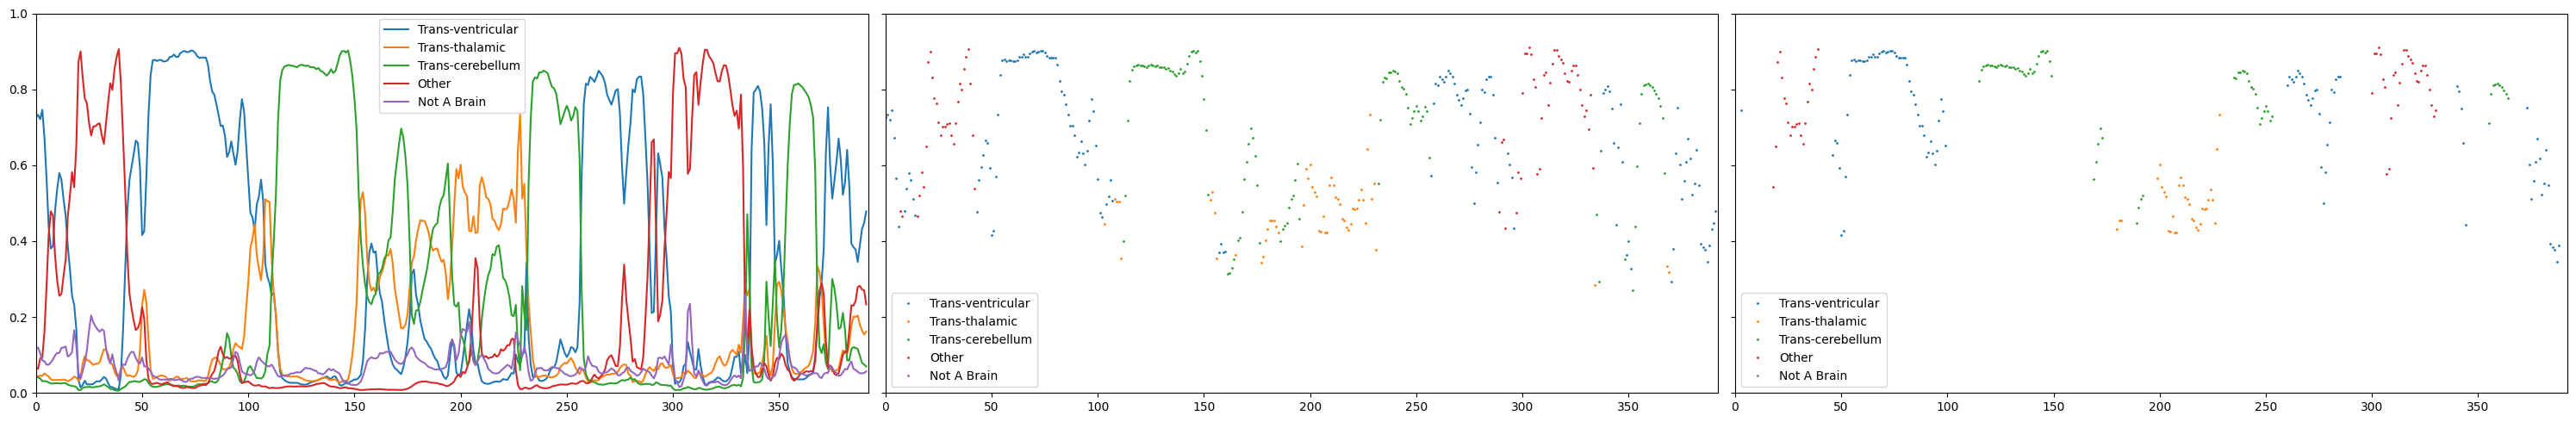

In [4]:
def plot_probabilities(y_hats, ax):
    x = list(range(y_hats.shape[0]))

    for i, label in enumerate(label_def):
        ax.plot(x, y_hats[:, i], label=label)

    ax.legend()


def plot_best_probabilities(y_hats, ax):
    x = torch.zeros((y_hats.shape[1], 0)).tolist()
    y = torch.zeros((y_hats.shape[1], 0)).tolist()

    for i, y_hat in enumerate(y_hats):
        best = torch.argmax(y_hat)
        x[best].append(i)
        y[best].append(y_hat[best])

    for i, label in enumerate(label_def):
        ax.plot(x[i], y[i], "o", markersize=1, label=label)

    ax.legend()


def is_stable(y, i):
    min_i = max(0, i - window)
    max_i = min(i + window, len(y) - 1)

    if min_i > i - window or max_i < i + window:
        return False

    for j in range(min_i, max_i + 1):
        if y[j] == 0.0:
            return False

    return True


def plot_filtered_probabilities(y_hats, ax):
    x = torch.arange(0, y_hats.shape[0]).int().repeat(y_hats.shape[1], 1).tolist()
    y = torch.zeros((y_hats.shape[1], y_hats.shape[0])).tolist()

    for i, y_hat in enumerate(y_hats):
        best = torch.argmax(y_hat)
        y[best][i] = y_hat[best]

    for i in range(len(y)):
        to_delete = []

        for j in range(len(y[i])):
            if not is_stable(y[i], j):
                to_delete.append(j)

        to_delete.sort(reverse=True)
        for j in to_delete:
            x[i].pop(j)
            y[i].pop(j)

    for i, label in enumerate(label_def):
        ax.plot(x[i], y[i], "o", markersize=1, label=label)

    ax.legend()


def plot_base_probabilities(y_hats):
    ncols = 3
    nrows = len(y_hats)
    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        sharex=True,
        sharey=True,
        squeeze=False,
        tight_layout=True,
        figsize=(10 * ncols, 5 * nrows),
    )

    for i in range(nrows):
        plot_probabilities(y_hats[i], axes[i, 0])
        plot_best_probabilities(y_hats[i], axes[i, 1])
        plot_filtered_probabilities(y_hats[i], axes[i, 2])

    for ax in axes:
        ax[0].set_xlim(left=0, right=y_hats.shape[1])
        ax[0].set_ylim(bottom=0, top=1)


label_def = FetalBrainPlanesDataset.labels

window = 3
temperature = 1.0
y_hats_ = F.softmax(logits / temperature, dim=2)
plot_base_probabilities(y_hats_[:1])

# fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
# # plot_probabilities(y_hats[0], axes)
# # plot_best_probabilities(y_hats[0], axes)
# plot_filtered_probabilities(y_hats[0], axes)
# axes.set_xlim(left=0, right=y_hats.shape[1])
# axes.set_ylim(bottom=0, top=1)

# Testing of quality value

In [ ]:
y_hats_ = torch.tensor(
    [
        [[1.0, 2.0, 3.0], [2.0, 3.0, 4.0], [3.0, 4.0, 5.0], [1.0, 3.0, 2.0], [1.0, 3.0, 2.0]],
        [[1.0, 4.0, 2.0], [2.0, 4.0, 3.0], [3.0, 4.0, 6.0], [1.0, 4.0, 2.0], [1.0, 5.0, 2.0]],
    ]
)
print(y_hats_.shape)

pred = torch.argmax(y_hats_, dim=2)
print(pred.shape)
print(pred)

y_hats_ = y_hats_ * F.one_hot(pred)
# mask = F.one_hot(pred) == 0
# y_hats_ = torch.masked_fill(y_hats_, mask, 0.0)

print(y_hats_)

In [ ]:
window = 1
for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
        min_j = max(0, j - window)
        max_j = min(j + window + 1, pred.shape[1])

        if not torch.all(pred[i, min_j:max_j] == pred[i, j]):
            y_hats_[i, j, pred[i, j]] = 0

y_hats_

In [ ]:
window = 1
for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
        if torch.sum(pred[i, j - window : j + window + 1] == pred[i, j]) < 1 + 2 * window:
            y_hats_[i, j, pred[i, j]] = 0

print(y_hats_.shape)
y_hats_

In [ ]:
y_hats__ = torch.mean(y_hats_, dim=0)
print(y_hats__.shape)
print(y_hats__)

plates = y_hats__[:, :2]
other = y_hats__[:, 2:]

quality = torch.sum(plates, dim=1) - torch.sum(other, dim=1)
print(quality)

quality = quality / torch.sum(plates > 0, dim=1)
zaro_mask = torch.eq(quality > 0, False)
torch.masked_fill(quality, zaro_mask, 0.0)

# Testing of quality value 2

In [ ]:
y_hats_ = torch.tensor(
    [
        [[1.0, 2.0, 3.0], [2.0, 3.0, 4.0], [3.0, 4.0, 5.0], [1.0, 3.0, 2.0], [1.0, 3.0, 2.0]],
        [[1.0, 4.0, 2.0], [2.0, 4.0, 3.0], [3.0, 4.0, 6.0], [1.0, 4.0, 2.0], [1.0, 5.0, 2.0]],
    ]
)
print(y_hats_.shape)

y_hats_ = torch.mean(y_hats_, 0)
print(y_hats_.shape)
print(y_hats_)

# window moving average
window = 1
y_hats_ = F.pad(y_hats_, pad=(0, 0, window, window), mode="constant", value=float("nan"))
y_hats_ = y_hats_.unfold(dimension=0, size=window * 2 + 1, step=1)
y_hats_ = torch.nanmean(y_hats_, dim=2)

print(y_hats_.shape)
print(y_hats_)

In [ ]:
y_hats_ = torch.tensor(
    [
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [2.0, 2.0, 2.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        # [1.0, 2.0, 1.0],
        # [2.0, 2.0, 1.0],
        # [1.0, 2.0, 2.0],
        # [2.0, 2.0, 2.0]
    ]
)
print("y_hats:\n", y_hats_)
print("")

width = 1
window = width * 2 + 1
sigma = window / 4
distance = torch.arange(-width, width + 1, dtype=torch.float)
gaussian = torch.exp(-(distance**2) / (2 * sigma**2))

print("distance:\n", distance)
print("gaussian:\n", gaussian)
print("")

weight_sum = torch.ones(y_hats_.shape)
weight_sum = F.pad(weight_sum, pad=(0, 0, width, width), mode="constant", value=float("nan"))
weight_sum = weight_sum.unfold(dimension=0, size=window, step=1)
weight_sum = weight_sum * gaussian
weight_sum = torch.nansum(weight_sum, dim=2)

print("weight_sum:\n", weight_sum)
print("")

y_hats_ = F.pad(y_hats_, pad=(0, 0, width, width), mode="constant", value=float("nan"))
y_hats_ = y_hats_.unfold(dimension=0, size=window, step=1)
y_hats_ = y_hats_ * gaussian
y_hats_ = torch.nansum(y_hats_, dim=2)

print("weighted_sum:\n", y_hats_)
print("")

y_hats_ / weight_sum

In [ ]:
y_hats_ = torch.tensor(
    [
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [2.0, 2.0, 2.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0],
        # [1.0, 2.0, 1.0],
        # [2.0, 2.0, 1.0],
        # [1.0, 2.0, 2.0],
        # [2.0, 2.0, 2.0]
    ]
)
width = 1
window = width * 2 + 1
sigma = window / 4
distance = torch.arange(-width, width + 1, dtype=torch.float)
gaussian = torch.exp(-(distance**2) / (2 * sigma**2))

weight_sum = torch.ones(y_hats_.shape)
weight_sum = F.pad(weight_sum, pad=(0, 0, width, width), mode="constant", value=0)
weight_sum = weight_sum.unfold(dimension=0, size=window, step=1)
weight_sum = weight_sum * gaussian
weight_sum = torch.nansum(weight_sum, dim=2)

y_hats_ = F.pad(y_hats_, pad=(0, 0, width, width), mode="constant", value=0)
y_hats_ = y_hats_.unfold(dimension=0, size=window, step=1)
y_hats_ = y_hats_ * gaussian
y_hats_ = torch.nansum(y_hats_, dim=2)

y_hats_ / weight_sum

In [ ]:
width = 5
sigma = (width * 2 + 1) / 4

distance = torch.arange(-width, width + 1, dtype=torch.float)
gaussian = torch.exp(-(distance**2) / (2 * sigma**2))

fig, ax = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
ax.plot(distance, gaussian)
fig.show()

In [ ]:
from scipy import signal

gaussian = signal.windows.gaussian(width * 2 + 1, std=sigma)

fig, ax = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
ax.plot(distance, gaussian)
fig.show()

In [ ]:
# (the best prediction - sum of the rest prediction)
a = y_hats_[:, :2]
print(a)
a = torch.amax(a, dim=1)
print(a)
a = a - torch.sum(y_hats_, dim=1)
print(a)
b = torch.eq(a > 0, False)
a.masked_fill_(b, 0.0)

# plates = y_hats[:, :3]
# quality = torch.amax(plates, dim=1)
# quality = (quality * 2) - torch.sum(y_hats, dim=1)
# zaro_mask = torch.eq(quality > 0, False)
# quality.masked_fill_(zaro_mask, 0.0)

# Calculate quality value

In [5]:
def plot_quality(y_hats: Tensor, quality: Tensor):
    fig, axes = plt.subplots(ncols=1, nrows=3, tight_layout=True, figsize=(10, 15))

    plot_mean_filtered_probabilities(y_hats, axes[0])
    plot_quality_dots(quality, axes[1])
    plot_quality_line(quality, axes[2])

    return fig


def plot_mean_filtered_probabilities(y_hats: Tensor, ax):
    for i, label in enumerate(label_def):
        x, y = extract_nonzero_values(y_hats[:, i])
        ax.plot(x, y, "o", markersize=1, label=label)
        ax.legend()

    ax.set_xlim(left=0, right=len(y_hats))
    ax.set_ylim(bottom=0, top=1)


def plot_quality_dots(quality: Tensor, ax):
    ax.plot(range(len(quality)), quality, "o", markersize=2, color="tab:gray")

    ax.set_xlim(left=0, right=len(quality))
    ax.set_ylim(bottom=0, top=1)


def plot_quality_line(quality: Tensor, ax):
    ax.plot(range(len(quality)), quality, color="tab:gray")

    ax.set_xlim(left=0, right=len(quality))
    ax.set_ylim(bottom=0, top=1)


def extract_nonzero_values(y_hats):
    x = []
    y = []
    for i, y_hat in enumerate(y_hats):
        if y_hat > 0:
            x.append(i)
            y.append(y_hat)
    return x, y

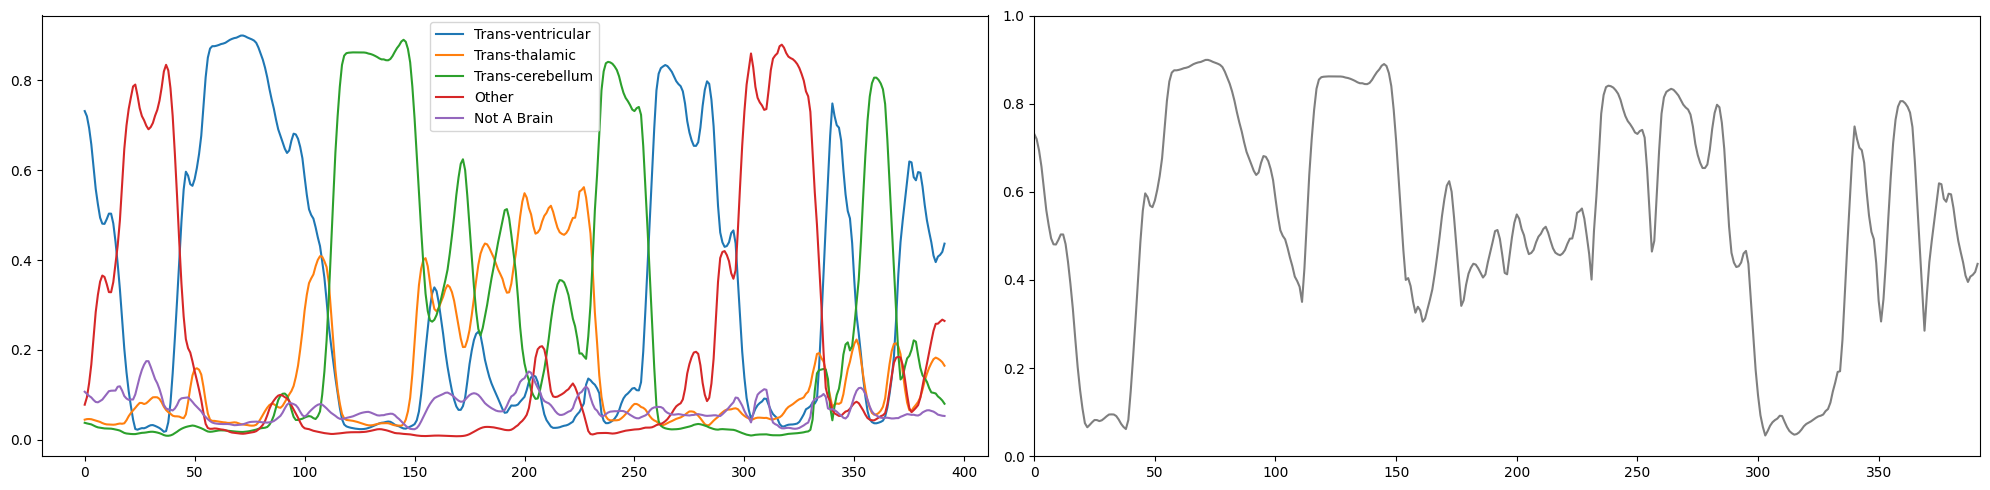

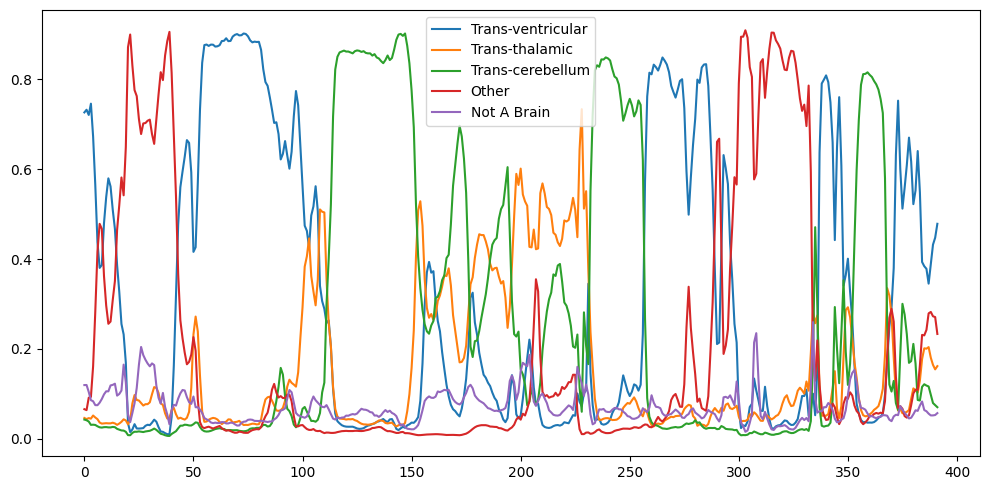

In [7]:
def plot_quality2(y_hats_: Tensor, quality: Tensor):
    fig, axes = plt.subplots(ncols=2, nrows=1, tight_layout=True, figsize=(20, 5))

    plot_probabilities(y_hats_, axes[0])
    plot_quality_line(quality, axes[1])

    return fig


def calculate_quality(y_hats: Tensor):  # test (mean + rolling window mean)

    # average of all transformations
    y_hats = torch.mean(y_hats, dim=0)

    # rolling window average
    y_hats = F.pad(y_hats, pad=(0, 0, window, window), mode="constant", value=float("nan"))
    y_hats = y_hats.unfold(dimension=0, size=window * 2 + 1, step=1)
    y_hats = torch.nanmean(y_hats, dim=2)

    # the best prediction
    plates = y_hats[:, :3]
    quality = torch.amax(plates, dim=1)

    return y_hats, quality


window = 3
temperature = 1.0
y_hats_ = F.softmax(logits / temperature, dim=2)
# y_hats_ = y_hats.clone()
label_def = FetalBrainPlanesDataset.labels

y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()

# fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
# # plot_mean_filtered_probabilities(y_hats_, axes)
# plot_quality_dots(quality, axes)
# # plot_quality_line(quality, axes)
# fig.show()

fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
plot_probabilities(torch.mean(F.softmax(logits / temperature, dim=2), dim=0), axes)

In [ ]:
def calculate_quality(y_hats: Tensor):  # test (mean + rolling window mean + normalization)

    # average of all transformations
    y_hats = torch.mean(y_hats, dim=0)

    # rolling window average
    y_hats = F.pad(y_hats, pad=(0, 0, window, window), mode="constant", value=float("nan"))
    y_hats = y_hats.unfold(dimension=0, size=window * 2 + 1, step=1)
    y_hats = torch.nanmean(y_hats, dim=2)

    # (the best prediction - sum of the rest prediction)
    plates = y_hats[:, :3]
    quality = torch.amax(plates, dim=1)
    quality = (quality * 2) - torch.sum(y_hats, dim=1)
    zaro_mask = torch.eq(quality > 0, False)
    quality.masked_fill_(zaro_mask, 0.0)

    return y_hats, quality


window = 3
temperature = 1.0
y_hats_ = F.softmax(logits / temperature, dim=2)
# y_hats_ = y_hats.clone()
label_def = FetalBrainPlanesDataset.labels

y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()


# fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
# # plot_mean_filtered_probabilities(y_hats_, axes)
# plot_quality_dots(quality, axes)
# # plot_quality_line(quality, axes)
# fig.show()

In [ ]:
def calculate_quality(y_hats: Tensor):  # test (best + mean + normalization)
    # select highest prediction
    pred = torch.argmax(y_hats, dim=2)
    y_hats = y_hats * F.one_hot(pred, num_classes=y_hats.shape[2])

    # average of all transformations
    y_hats = torch.mean(y_hats, dim=0)

    # (the best prediction - sum of the rest prediction)
    plates = y_hats[:, :3]
    quality = torch.amax(plates, dim=1)
    quality = (quality * 2) - torch.sum(y_hats, dim=1)
    zaro_mask = torch.eq(quality > 0, False)
    quality.masked_fill_(zaro_mask, 0.0)

    return y_hats, quality


window = 3
temperature = 1.0
y_hats_ = F.softmax(logits / temperature, dim=2)
# y_hats_ = y_hats.clone()
label_def = FetalBrainPlanesDataset.labels

y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()


# fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
# # plot_mean_filtered_probabilities(y_hats_, axes)
# plot_quality_dots(quality, axes)
# # plot_quality_line(quality, axes)
# fig.show()

In [ ]:
def calculate_quality(y_hats: Tensor):  # test (best + mean + rolling window mean + normalization)
    # select highest prediction
    pred = torch.argmax(y_hats, dim=2)
    y_hats = y_hats * F.one_hot(pred, num_classes=y_hats.shape[2])

    # average of all transformations
    y_hats = torch.mean(y_hats, dim=0)

    # rolling window average
    y_hats = F.pad(y_hats, pad=(0, 0, window, window), mode="constant", value=float("nan"))
    y_hats = y_hats.unfold(dimension=0, size=window * 2 + 1, step=1)
    y_hats = torch.nanmean(y_hats, dim=2)

    # (the best prediction - sum of the rest prediction)
    plates = y_hats[:, :3]
    quality = torch.amax(plates, dim=1)
    quality = (quality * 2) - torch.sum(y_hats, dim=1)
    zaro_mask = torch.eq(quality > 0, False)
    quality.masked_fill_(zaro_mask, 0.0)

    return y_hats, quality


window = 3
temperature = 1.0
y_hats_ = F.softmax(logits / temperature, dim=2)
# y_hats_ = y_hats.clone()
label_def = FetalBrainPlanesDataset.labels

y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()


# fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
# # plot_mean_filtered_probabilities(y_hats_, axes)
# plot_quality_dots(quality, axes)
# # plot_quality_line(quality, axes)
# fig.show()

In [ ]:
def calculate_quality(y_hats: Tensor):  # Selected (best + remove unstable + mean + normalization)
    # select highest prediction
    pred = torch.argmax(y_hats, dim=2)
    y_hats = y_hats * F.one_hot(pred, num_classes=y_hats.shape[2])

    # remove predictions that are inconsistent
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            min_j = max(0, j - window)
            max_j = min(j + window + 1, pred.shape[1])

            if not torch.all(torch.eq(pred[i, min_j:max_j], pred[i, j])):
                y_hats[i, j, pred[i, j]] = 0

    # average of all transformations
    y_hats = torch.mean(y_hats, dim=0)

    # (the best prediction - sum of the rest prediction)
    plates = y_hats[:, :3]
    quality = torch.amax(plates, dim=1)
    quality = (quality * 2) - torch.sum(y_hats, dim=1)
    zaro_mask = torch.eq(quality > 0, False)
    quality.masked_fill_(zaro_mask, 0.0)

    return y_hats, quality


window = 3
temperature = 1.0
y_hats_ = F.softmax(logits / temperature, dim=2)
# y_hats_ = y_hats.clone()
label_def = FetalBrainPlanesDataset.labels

y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()


# fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
# # plot_mean_filtered_probabilities(y_hats_, axes)
# plot_quality_dots(quality, axes)
# # plot_quality_line(quality, axes)
# fig.show()

In [ ]:
def calculate_quality(y_hats: Tensor):  # test (best + remove unstable + mean + rolling window mean + normalization)
    # select highest prediction
    pred = torch.argmax(y_hats, dim=2)
    y_hats = y_hats * F.one_hot(pred, num_classes=y_hats.shape[2])

    # remove predictions that are inconsistent
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            min_j = max(0, j - window)
            max_j = min(j + window + 1, pred.shape[1])

            if not torch.all(torch.eq(pred[i, min_j:max_j], pred[i, j])):
                y_hats[i, j, pred[i, j]] = 0

    # average of all transformations
    y_hats = torch.mean(y_hats, dim=0)

    # rolling window average
    y_hats = F.pad(y_hats, pad=(0, 0, window, window), mode="constant", value=float("nan"))
    y_hats = y_hats.unfold(dimension=0, size=window * 2 + 1, step=1)
    y_hats = torch.nanmean(y_hats, dim=2)

    # (the best prediction - sum of the rest prediction)
    plates = y_hats[:, :3]
    quality = torch.amax(plates, dim=1)
    quality = (quality * 2) - torch.sum(y_hats, dim=1)
    zaro_mask = torch.eq(quality > 0, False)
    quality.masked_fill_(zaro_mask, 0.0)

    return y_hats, quality


window = 3
temperature = 1.0
y_hats_ = F.softmax(logits / temperature, dim=2)
# y_hats_ = y_hats.clone()
label_def = FetalBrainPlanesDataset.labels

y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()


# fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
# # plot_mean_filtered_probabilities(y_hats_, axes)
# plot_quality_dots(quality, axes)
# # plot_quality_line(quality, axes)
# fig.show()

In [ ]:
def calculate_quality(y_hats: Tensor):  # test (mean + Gaussian moving average + normalization)

    # average of all transformations
    y_hats = torch.mean(y_hats, dim=0)

    # gaussian moving average
    distance = torch.arange(-gma_width, gma_width + 1, dtype=torch.float)
    gaussian = torch.exp(-(distance**2) / (2 * gma_sigma**2))

    weight_sum = torch.ones(y_hats.shape)
    weight_sum = F.pad(weight_sum, pad=(0, 0, gma_width, gma_width), mode="constant", value=0)
    weight_sum = weight_sum.unfold(dimension=0, size=gma_window, step=1)
    weight_sum = weight_sum * gaussian
    weight_sum = torch.nansum(weight_sum, dim=2)

    y_hats = F.pad(y_hats, pad=(0, 0, gma_width, gma_width), mode="constant", value=0)
    y_hats = y_hats.unfold(dimension=0, size=gma_window, step=1)
    y_hats = y_hats * gaussian
    y_hats = torch.nansum(y_hats, dim=2)

    y_hats = y_hats / weight_sum

    # (the best prediction - sum of the rest prediction)
    plates = y_hats[:, :3]
    quality = torch.amax(plates, dim=1)
    quality = (quality * 2) - torch.sum(y_hats, dim=1)
    zaro_mask = torch.eq(quality > 0, False)
    quality.masked_fill_(zaro_mask, 0.0)

    return y_hats, quality


window = 3

gma_width = 3
gma_window = gma_width * 2 + 1
gma_sigma = gma_window / 4

temperature = 1.0
y_hats_ = F.softmax(logits / temperature, dim=2)
# y_hats_ = y_hats.clone()
label_def = FetalBrainPlanesDataset.labels

y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()


# fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
# # plot_mean_filtered_probabilities(y_hats_, axes)
# plot_quality_dots(quality, axes)
# # plot_quality_line(quality, axes)
# fig.show()

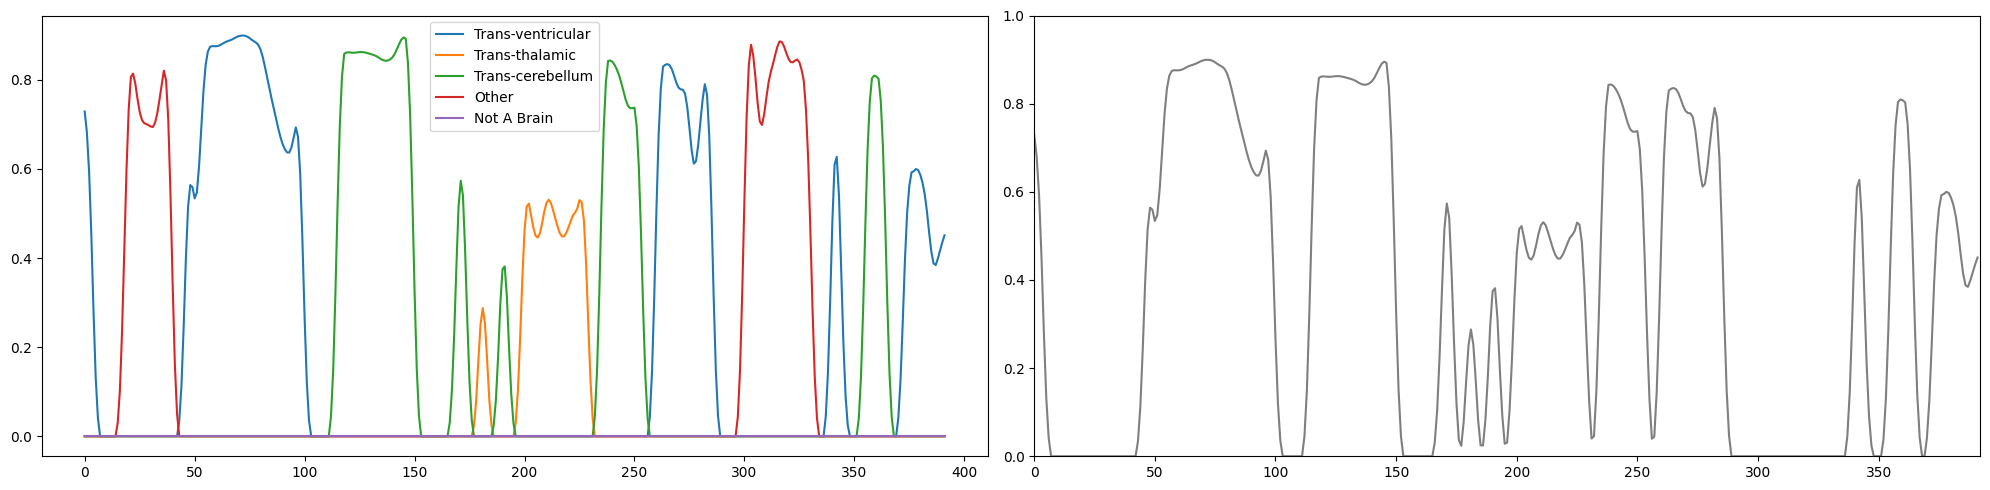

In [8]:
def calculate_quality(
    y_hats: Tensor,
):  # new selected (best + remove unstable + mean + Gaussian moving average + normalization)
    # select highest prediction
    pred = torch.argmax(y_hats, dim=2)
    y_hats = y_hats * F.one_hot(pred, num_classes=y_hats.shape[2])

    # remove predictions that are inconsistent
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            min_j = max(0, j - window)
            max_j = min(j + window + 1, pred.shape[1])

            if not torch.all(torch.eq(pred[i, min_j:max_j], pred[i, j])):
                y_hats[i, j, pred[i, j]] = 0

    # average of all transformations
    y_hats = torch.mean(y_hats, dim=0)

    # gaussian moving average
    distance = torch.arange(-gma_width, gma_width + 1, dtype=torch.float)
    gaussian = torch.exp(-(distance**2) / (2 * gma_sigma**2))

    weight_sum = torch.ones(y_hats.shape)
    weight_sum = F.pad(weight_sum, pad=(0, 0, gma_width, gma_width), mode="constant", value=0)
    weight_sum = weight_sum.unfold(dimension=0, size=gma_window, step=1)
    weight_sum = weight_sum * gaussian
    weight_sum = torch.nansum(weight_sum, dim=2)

    y_hats = F.pad(y_hats, pad=(0, 0, gma_width, gma_width), mode="constant", value=0)
    y_hats = y_hats.unfold(dimension=0, size=gma_window, step=1)
    y_hats = y_hats * gaussian
    y_hats = torch.nansum(y_hats, dim=2)

    y_hats = y_hats / weight_sum

    # (the best prediction - sum of the rest prediction)
    plates = y_hats[:, :3]
    quality = torch.amax(plates, dim=1)
    quality = (quality * 2) - torch.sum(y_hats, dim=1)
    zaro_mask = torch.eq(quality > 0, False)
    quality.masked_fill_(zaro_mask, 0.0)

    return y_hats, quality


window = 3

gma_width = 3
gma_window = gma_width * 2 + 1
gma_sigma = gma_window / 4

temperature = 1.0
y_hats_ = F.softmax(logits / temperature, dim=2)
# y_hats_ = y_hats.clone()
label_def = FetalBrainPlanesDataset.labels

y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()


# fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
# # plot_mean_filtered_probabilities(y_hats_, axes)
# plot_quality_dots(quality, axes)
# # plot_quality_line(quality, axes)
# fig.show()

In [ ]:
def calculate_quality(y_hats: Tensor):
    # select highest prediction
    pred = torch.argmax(y_hats, dim=2)
    y_hats = y_hats * F.one_hot(pred, num_classes=y_hats.shape[2])

    # remove predictions that are inconsistent
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            min_j = max(0, j - window)
            max_j = min(j + window + 1, pred.shape[1])

            if not torch.all(torch.eq(pred[i, min_j:max_j], pred[i, j])):
                y_hats[i, j, pred[i, j]] = 0

    # average of all transformations
    y_hats = torch.mean(y_hats, dim=0)  # ???

    # (sum planes' prediction - sum no planes' prediction) / (number of planes' prediction greater than 0)
    plates = y_hats[:, :3]
    other = y_hats[:, 3:]
    quality = torch.sum(plates, dim=1) - torch.sum(other, dim=1)
    quality = quality / torch.sum(plates > 0, dim=1)
    zaro_mask = torch.eq(quality > 0, False)
    quality.masked_fill_(zaro_mask, 0.0)

    return y_hats, quality


window = 3
temperature = 1.0
y_hats_ = F.softmax(logits / temperature, dim=2)
# y_hats_ = y_hats.clone()
label_def = FetalBrainPlanesDataset.labels

y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()

In [ ]:
def calculate_quality(y_hats: Tensor):
    # select highest prediction
    pred = torch.argmax(y_hats, dim=2)
    y_hats = y_hats * F.one_hot(pred, num_classes=y_hats.shape[2])

    # remove predictions that are inconsistent
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            min_j = max(0, j - window)
            max_j = min(j + window + 1, pred.shape[1])

            if not torch.all(torch.eq(pred[i, min_j:max_j], pred[i, j])):
                y_hats[i, j, pred[i, j]] = 0

    # average of all transformations
    y_hats = torch.mean(y_hats, dim=0)

    # (the best prediction - sum of the rest prediction)
    quality = torch.amax(y_hats, dim=1)
    quality = (quality * 2) - torch.sum(y_hats, dim=1)
    zaro_mask = torch.eq(quality > 0, False)
    quality.masked_fill_(zaro_mask, 0.0)

    return y_hats, quality


window = 3
temperature = 1.0
y_hats_ = F.softmax(logits / temperature, dim=2)
# y_hats_ = y_hats.clone()
label_def = FetalBrainPlanesDataset.labels

y_hats_, quality = calculate_quality(y_hats_)
# plot_quality(y_hats_, quality).show()


fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
# plot_mean_filtered_probabilities(y_hats_, axes)
plot_quality_dots(quality, axes)
# plot_quality_line(quality, axes)
fig.show()

In [ ]:
def load_logits(data_path: Path):
    dense = []
    for video_path in sorted(data_path.iterdir()):
        path = sorted(video_path.iterdir())[0]
        logits, _, _ = torch.load(path)
        dense.append(logits)
    return torch.cat(dense)


def save_std_mean(data_path: Path, logits):
    std_mean = torch.std_mean(logits, unbiased=False, dim=0)
    torch.save(std_mean, f"{data_path}/std_mean.pt")
    print(std_mean[0].shape)


path = root / "data" / "US_VIDEOS_tran_" / "data"
dense = load_logits(path / "train")
save_std_mean(path, dense)

# Test transfor operation to quality plot

In [ ]:
# device = "cpu"
device = "cuda"
model.to(device)
video_path = sorted((path / "videos" / "test").iterdir())[1]

window = 3
temperature = 1.0

In [ ]:
def plot_quality(y_hats: Tensor, quality: Tensor):
    fig, axes = plt.subplots(ncols=2, nrows=1, tight_layout=True, figsize=(20, 5))

    plot_mean_filtered_probabilities(y_hats, axes[0])
    plot_quality_line(quality, axes[1])

    return fig

## Base

In [ ]:
_, logits, y_hats = lable_transform_video(
    video_path=video_path,
    horizontal_flips=[False],
    vertical_flips=[False],
    rotate_degrees=[0],
    translates=[(0.0, 0.0)],
    scales=[1.0],
)
y_hats.shape

In [ ]:
y_hats_ = F.softmax(logits / temperature, dim=2)

plot_base_probabilities(y_hats_[:1])

In [ ]:
y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()

## Horizontal flip

In [ ]:
_, logits, y_hats = lable_transform_video(
    video_path=video_path,
    horizontal_flips=[False, True],
    vertical_flips=[False],
    rotate_degrees=[0],
    translates=[(0.0, 0.0)],
    scales=[1.0],
)

y_hats.shape

In [ ]:
y_hats_ = F.softmax(logits / temperature, dim=2)

plot_base_probabilities(y_hats_[:2])

In [ ]:
y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()

## Vertical flip

In [ ]:
_, logits, y_hats = lable_transform_video(
    video_path=video_path,
    horizontal_flips=[False],
    vertical_flips=[False, True],
    rotate_degrees=[0],
    translates=[(0.0, 0.0)],
    scales=[1.0],
)

y_hats.shape

In [ ]:
y_hats_ = F.softmax(logits / temperature, dim=2)

plot_base_probabilities(y_hats_[:2])

In [ ]:
y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()

## Rotation (-15, -10, ..., 15)

In [ ]:
_, logits, y_hats = lable_transform_video(
    video_path=video_path,
    horizontal_flips=[False],
    vertical_flips=[False],
    rotate_degrees=[0, -5, -10, -15, 5, 10, 15],
    translates=[(0.0, 0.0)],
    scales=[1.0],
)
y_hats.shape

In [ ]:
y_hats_ = F.softmax(logits / temperature, dim=2)

plot_base_probabilities(y_hats_[:7])

In [ ]:
y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()

## Translates -+10%

In [ ]:
_, logits, y_hats = lable_transform_video(
    video_path=video_path,
    horizontal_flips=[False],
    vertical_flips=[False],
    rotate_degrees=[0],
    translates=[(0.0, 0.0), (0.1, 0.1), (-0.1, 0.1), (-0.1, -0.1), (0.1, -0.1)],
    scales=[1.0],
)
y_hats.shape

In [ ]:
y_hats_ = F.softmax(logits / temperature, dim=2)

plot_base_probabilities(y_hats_[:5])

In [ ]:
y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()

## Scale 100-120%

In [ ]:
_, logits, y_hats = lable_transform_video(
    video_path=video_path,
    horizontal_flips=[False],
    vertical_flips=[False],
    rotate_degrees=[0],
    translates=[(0.0, 0.0)],
    scales=[1.00, 1.05, 1.10, 1.15, 1.20],
)
y_hats.shape

In [ ]:
y_hats_ = F.softmax(logits / temperature, dim=2)

plot_base_probabilities(y_hats_[:5])

In [ ]:
y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()

## All (1)

In [ ]:
_, logits, y_hats = lable_transform_video(
    video_path=video_path,
    horizontal_flips=[False, True],
    vertical_flips=[False, True],
    rotate_degrees=[0, -15, 15],
    translates=[(0.0, 0.0), (0.1, 0.1), (-0.1, 0.1), (-0.1, -0.1), (0.1, -0.1)],
    scales=[1.0, 1.2],
)
y_hats.shape

In [ ]:
y_hats_ = F.softmax(logits / temperature, dim=2)

plot_base_probabilities(y_hats_[:1])

In [ ]:
y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()

# fig, axes = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(10, 5))
# # plot_mean_filtered_probabilities(y_hats_, axes)
# plot_quality_line(quality, axes)
# fig.show()

## All (2)

In [ ]:
_, logits, y_hats = lable_transform_video(
    video_path=video_path,
    horizontal_flips=[False, True],
    vertical_flips=[False, True],
    rotate_degrees=[0, -5, -10, 5, 10],
    translates=[(0.0, 0.0), (0.1, 0.1), (-0.1, 0.1), (-0.1, -0.1), (0.1, -0.1)],
    scales=[1.00, 1.05, 1.10, 1.15, 1.20],
)
y_hats.shape

In [ ]:
y_hats_ = F.softmax(logits / temperature, dim=2)

plot_base_probabilities(y_hats_[:1])

In [ ]:
y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()

## All (3)

In [ ]:
_, logits, y_hats = lable_transform_video(
    video_path=video_path,
    horizontal_flips=[False, True],
    vertical_flips=[False, True],
    rotate_degrees=[0, -5, -10, -15, 5, 10, 15],
    translates=list(itertools.product([0.0, 0.1, -0.1], [0.0, 0.1, -0.1])),
    scales=[1.00, 1.05, 1.10, 1.15, 1.20],
)
y_hats.shape

In [ ]:
y_hats_ = F.softmax(logits / temperature, dim=2)

plot_base_probabilities(y_hats_[:1])

In [ ]:
y_hats_, quality = calculate_quality(y_hats_)
plot_quality(y_hats_, quality).show()

# Test 1

In [ ]:
def test_video(checkpoint_file):
    global model

    checkpoint = sorted(checkpoint_file.glob("checkpoints/epoch_*.ckpt"))[-1]
    model = FetalLitModule.load_from_checkpoint(str(checkpoint))
    # disable randomness, dropout, etc...
    model.to(device)
    model.eval()

    # _, logits, y_hats = lable_transform_video(
    #     video_path=video_path,
    #     horizontal_flips=[False],
    #     vertical_flips=[False],
    #     rotate_degrees=[0],
    #     translates=[(0.0, 0.0)],
    #     scales=[1.0],
    # )
    _, logits, y_hats = lable_transform_video(
        video_path=video_path,
        horizontal_flips=[False, True],
        vertical_flips=[False, True],
        rotate_degrees=[0, -5, -10, 5, 10],
        translates=[(0.0, 0.0), (0.1, 0.1), (-0.1, 0.1), (-0.1, -0.1), (0.1, -0.1)],
        scales=[1.00, 1.05, 1.10, 1.15, 1.20],
    )
    # _, logits, y_hats = lable_transform_video(
    #     video_path=video_path,
    #     horizontal_flips=[False, True],
    #     vertical_flips=[False, True],
    #     rotate_degrees=[0, -5, -10, -15, 5, 10, 15],
    #     translates=list(itertools.product([0.0, 0.1, -0.1], [0.0, 0.1, -0.1])),
    #     scales=[1.00, 1.05, 1.10, 1.15, 1.20],
    # )

    y_hats_ = F.softmax(logits / temperature, dim=2)

    y_hats_, quality = calculate_quality(y_hats_)
    plot_quality(y_hats_, quality).show()

In [ ]:
# device = "cpu"
device = "cuda"
model.to(device)
video_path = sorted((path / "videos" / "test").iterdir())[1]

window = 3
temperature = 1.0

In [ ]:
# test 0
video_path = sorted((path / "videos" / "test").iterdir())[0]
test_video(checkpoint_file=root / "logs" / "train" / "multiruns" / "2023-11-09_15-55-39" / "0")  # feager-deluge-2718

# Creation of quality plot

In [9]:
# device = "cpu"
device = "cuda"
model.to(device)
video_path = sorted((path / "videos" / "test").iterdir())[0]

window = 3
temperature = 1.0

In [10]:
_, logits, y_hats = lable_transform_video(
    video_path=video_path,
    horizontal_flips=[False, True],
    vertical_flips=[False, True],
    rotate_degrees=[0, -5, -10, 5, 10],
    translates=[(0.0, 0.0), (0.1, 0.1), (-0.1, 0.1), (-0.1, -0.1), (0.1, -0.1)],
    scales=[1.00, 1.05, 1.10, 1.15, 1.20],
)
y_hats.shape

Label frames:   0%|          | 0/472 [00:00<?, ?it/s]

torch.Size([500, 472, 5])

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(6, 3))

plot_probabilities(y_hats[0], ax)

ax.set_xlim(left=0, right=y_hats.shape[1])
ax.set_ylim(bottom=0, top=1)

plt.ylabel("Probability", size="large")  # , size="16")
plt.xlabel("Video frame index", size="large")  # , size="16")
# ax.get_legend().remove()
ax.legend(fontsize="small", loc="lower right")

plt.show()
fig.savefig("plots/quality_1_class_probability.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(6, 3))

x = list(range(y_hats[0].shape[0]))
for i, label in enumerate(label_def):
    ax.plot(x, y_hats[0][:, i], "o", markersize=1, label=label)

ax.legend()

ax.set_xlim(left=0, right=y_hats.shape[1])
ax.set_ylim(bottom=0, top=1)

plt.ylabel("Probability", size="large")  # , size="16")
plt.xlabel("Video frame index", size="large")  # , size="16")
# ax.get_legend().remove()
ax.legend(fontsize="small", loc="lower right")

plt.show()
fig.savefig("plots/quality_1_class_probability_dotted.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(6, 3))

plot_best_probabilities(y_hats[0], ax)

ax.set_xlim(left=0, right=y_hats.shape[1])
ax.set_ylim(bottom=0, top=1)

plt.ylabel("Probability", size="large")  # , size="16")
plt.xlabel("Video frame index", size="large")  # , size="16")
# ax.get_legend().remove()
ax.legend(fontsize="small", loc="lower right")

plt.show()
fig.savefig("plots/quality_2_highest_probability.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(6, 3))

plot_filtered_probabilities(y_hats[0], ax)

ax.set_xlim(left=0, right=y_hats.shape[1])
ax.set_ylim(bottom=0, top=1)

plt.ylabel("Probability", size="large")  # , size="16")
plt.xlabel("Video frame index", size="large")  # , size="16")
# ax.get_legend().remove()
ax.legend(fontsize="small", loc="lower right")

plt.show()
fig.savefig("plots/quality_3_stable_probability.pdf", bbox_inches="tight")

In [ ]:
def plot_filtered_mean_probabilities(y_hats: Tensor, ax):
    # select highest prediction
    pred = torch.argmax(y_hats, dim=2)
    y_hats = y_hats * F.one_hot(pred, num_classes=y_hats.shape[2])

    # remove inconsistent predictions
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            min_j = max(0, j - window)
            max_j = min(j + window + 1, pred.shape[1])

            if not torch.all(torch.eq(pred[i, min_j:max_j], pred[i, j])):
                y_hats[i, j, pred[i, j]] = 0

    # average of all transformations
    y_hats = torch.mean(y_hats, dim=0)

    for i, label in enumerate(label_def):
        x, y = extract_nonzero_values(y_hats[:, i])
        ax.plot(x, y, "o", markersize=1, label=label)
        ax.legend()

    ax.set_xlim(left=0, right=len(y_hats))
    ax.set_ylim(bottom=0, top=1)


fig, ax = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(6, 3))

plot_filtered_mean_probabilities(y_hats, ax)

ax.set_xlim(left=0, right=y_hats.shape[1])
ax.set_ylim(bottom=0, top=1)

plt.ylabel("Probability", size="large")  # , size="16")
plt.xlabel("Video frame index", size="large")  # , size="16")
# ax.get_legend().remove()
ax.legend(fontsize="small", loc="lower right")

plt.show()
fig.savefig("plots/quality_4_mean_probability.pdf", bbox_inches="tight")

In [ ]:
def plot_filtered_mean_gma_probabilities(y_hats: Tensor, ax):
    # select highest prediction
    pred = torch.argmax(y_hats, dim=2)
    y_hats = y_hats * F.one_hot(pred, num_classes=y_hats.shape[2])

    # remove inconsistent predictions
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            min_j = max(0, j - window)
            max_j = min(j + window + 1, pred.shape[1])

            if not torch.all(torch.eq(pred[i, min_j:max_j], pred[i, j])):
                y_hats[i, j, pred[i, j]] = 0

    # average of all transformations
    y_hats = torch.mean(y_hats, dim=0)

    # gaussian moving average
    distance = torch.arange(-gma_width, gma_width + 1, dtype=torch.float)
    gaussian = torch.exp(-(distance**2) / (2 * gma_sigma**2))

    weight_sum = torch.ones(y_hats.shape)
    weight_sum = F.pad(weight_sum, pad=(0, 0, gma_width, gma_width), mode="constant", value=0)
    weight_sum = weight_sum.unfold(dimension=0, size=gma_window, step=1)
    weight_sum = weight_sum * gaussian
    weight_sum = torch.nansum(weight_sum, dim=2)

    y_hats = F.pad(y_hats, pad=(0, 0, gma_width, gma_width), mode="constant", value=0)
    y_hats = y_hats.unfold(dimension=0, size=gma_window, step=1)
    y_hats = y_hats * gaussian
    y_hats = torch.nansum(y_hats, dim=2)

    y_hats = y_hats / weight_sum

    for i, label in enumerate(label_def):
        x, y = extract_nonzero_values(y_hats[:, i])
        ax.plot(x, y, "o", markersize=1, label=label)
        ax.legend()

    ax.set_xlim(left=0, right=len(y_hats))
    ax.set_ylim(bottom=0, top=1)


fig, ax = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(6, 3))

plot_filtered_mean_gma_probabilities(y_hats, ax)

ax.set_xlim(left=0, right=y_hats.shape[1])
ax.set_ylim(bottom=0, top=1)

plt.ylabel("Probability", size="large")  # , size="16")
plt.xlabel("Video frame index", size="large")  # , size="16")
# ax.get_legend().remove()
ax.legend(fontsize="small", loc="lower right")

plt.show()
fig.savefig("plots/quality_5_gmv_probability.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(6, 3))


y_hats_ = F.softmax(logits / temperature, dim=2)
y_hats_, quality = calculate_quality(y_hats_)

ax.plot(range(len(quality)), quality, color="tab:cyan")

ax.set_xlim(left=0, right=len(quality))
ax.set_ylim(bottom=0, top=1)

plt.ylabel("Frame quality", size="large")
plt.xlabel("Video frame index", size="large")

plt.show()
fig.savefig("plots/quality_6_frame_quality.pdf", bbox_inches="tight")

# Evaluate frames quality

In [ ]:
img_size = (165, 240)

videoFrames = VideosFrameDataset(
    video_path=video_path,
    transform=torch.nn.Sequential(
        T.Grayscale(),
        T.Resize(img_size, antialias=True),
        T.ConvertImageDtype(torch.float32),
    ),
)

samples = 5
beans = 10

nrows = 1
figsize = 1.5
scale = img_size[0] / img_size[1]
fig, axes = plt.subplots(
    ncols=1,
    nrows=nrows,
    squeeze=True,
    tight_layout=True,
    figsize=(figsize * samples, figsize * scale * nrows * 3),
    #     figsize=(7, 3)
    #     dpi=600,
)


min_quality = 0.3
y_hat = quality
preds = torch.argmax(y_hats[0], dim=1)
qualities = []

rows = []
# For each label
for j in range(3):
    mask = torch.ne(preds, j)
    y_hat_label = torch.masked_fill(y_hat, mask, 0)
    # y_hat_label[:25] = 0  # omit first 25 frames
    best = torch.argsort(y_hat_label, descending=True)

    # delete frames from other classes and low quality frames
    best = [idx.item() for idx in best if y_hat_label[idx] != 0 and y_hat_label[idx] > min_quality]

    bean_size = int(len(best) / beans) + 1
    samples_ = [idx for i, idx in enumerate(best) if i % bean_size == 0][:samples]

    # for each sample
    frames = [videoFrames[idx] for idx in reversed(samples_)]
    row = torch.cat(frames, dim=2)
    rows.append(row)

    qualities.extend([y_hat[idx].item() for idx in reversed(samples_)])

img = torch.cat(rows, dim=1)
img = TF.to_pil_image(img)
img = TF.to_grayscale(img)
img = np.asarray(img)
axes.imshow(img, cmap="gray")
axes.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

for col_idx in range(samples):
    for label_idx in range(3):
        axes.text(
            img_size[1] * col_idx + img_size[1] - 10,
            img_size[0] * label_idx + 10,
            round(qualities[label_idx * samples + col_idx], 2),
            size="large",
            color="tab:cyan",
            bbox={"pad": 0, "color": (0, 0, 0, 0.3)},
            horizontalalignment="right",
            verticalalignment="top",
        )

for label_idx in range(3):
    axes.text(
        -30,
        img_size[0] * label_idx + img_size[0] / 2,
        label_def[label_idx].replace("-", "\n"),
        rotation=90,
        horizontalalignment="center",
        verticalalignment="center",
    )


plt.xlabel("Standard Planes", size="large")

plt.show()
fig.savefig("plots/samples_planes.pdf", bbox_inches="tight")

# Evaluate video
Add quality value to a video

In [ ]:
# poprawne
# video_path = root / "data" / "US_VIDEOS" / "videos" / "test" / "IMG_20220105_1_1.mp4"
# video_path = root / "data" / "US_VIDEOS" / "videos" / "test" / "IMG_20220531101504_0133.AVI"
# video_path = root / "data" / "US_VIDEOS" / "videos" / "train" / "IMG_20220531101504_0054.AVI"

# nie poprawne
# video_path = root / "data" / "US_VIDEOS" / "IMG_20211222_2_chor.avi"
video_path = root / "data" / "US_VIDEOS" / "IMG_20220615_2_19_Nieprawidłow_przykład.mp4"

video_path.exists()

In [ ]:
_, logits, y_hats = lable_transform_video(
    video_path=video_path,
    horizontal_flips=[False],
    vertical_flips=[False],
    rotate_degrees=[0],
    translates=[(0.0, 0.0)],
    scales=[1.00],
)
y_hats_, quality = calculate_quality(y_hats)
quality.shape

In [ ]:
_, logits, y_hats = lable_transform_video(
    video_path=video_path,
    horizontal_flips=[False, True],
    vertical_flips=[False, True],
    rotate_degrees=[0, -5, -10, -15, 5, 10, 15],
    translates=list(itertools.product([0.0, 0.1, -0.1], [0.0, 0.1, -0.1])),
    scales=[1.00, 1.05, 1.10, 1.15, 1.20],
)
y_hats_, quality = calculate_quality(y_hats)
quality.shape

In [ ]:
def put_text(frame, text, row):
    cv2.putText(
        frame,
        text,
        (column_padding, row_padding + row_size * row),
        cv2.FONT_HERSHEY_DUPLEX,
        1.5,
        (0, 255, 255),
        2,
        cv2.LINE_8,
    )


def put_probability_line(frame, probability, row):
    x = column_padding + 110
    y = row_padding - 15 + row_size * row

    cv2.line(frame, (x, y), (x + int(100 * probability), y), (0, 255, 255), 5)


def add_quality_to_video(video_path: Path, result_path: Path, quality: Tensor, y_hats: Tensor):
    vidcap = cv2.VideoCapture(str(video_path))

    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    size = (frame_width, frame_height)
    result = cv2.VideoWriter(str(result_path), cv2.VideoWriter_fourcc(*"avc1"), fps, size)

    for frame, q, y_hat in zip(_frame_iter(vidcap, "Label frames"), quality, y_hats):
        put_text(frame, f"QV: {q:.2f}", 1)

        put_text(frame, "TV:", 2)
        put_text(frame, "TT:", 3)
        put_text(frame, "TC:", 4)
        put_text(frame, "OT:", 5)
        put_text(frame, "NB:", 6)

        for i, probability in enumerate(y_hat):
            # print(probability.item())
            put_probability_line(frame, probability.item(), i + 2)

        result.write(frame)

    result.release()
    vidcap.release()


column_padding = 20
row_padding = 20
row_size = 50

result_video_path = root / "data" / "US_VIDEOS_QUALITY" / (video_path.stem + ".mp4")

add_quality_to_video(
    video_path=video_path,
    result_path=result_video_path,
    quality=quality,
    y_hats=y_hats[0],
)

In [ ]:
Video.from_file(str(result_video_path), width=500, loop=False)

# Video statistics

In [ ]:
def video_durations_statistics(path: Path):
    videos_path = path / "videos"
    durations = torch.cat(
        [
            video_durations(videos_path / "train"),
            video_durations(videos_path / "test"),
        ]
    )
    return durations.min(), durations.max(), torch.std_mean(durations)


def video_durations(videos_path: Path):
    durations = []
    videos = sorted(videos_path.iterdir())
    for video_path in tqdm(videos, desc="cound duration videos"):
        durations.append(video_duration(video_path))

    return torch.tensor(durations)


def video_duration(video_path: Path):
    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return frame_count / fps


min_duration, max_duration, (std_duration, mean_duration) = video_durations_statistics(path)

print("Duration")
print(f"min {min_duration}")
print(f"max {max_duration}")
print(f"std {std_duration}")
print(f"mean {mean_duration}")

# Evaluate RNN model

In [11]:
checkpoint_file = root / "logs" / "train" / "runs" / "2024-06-06_17-06-09"  # fragrant-sunset-4176

print(sorted(checkpoint_file.glob("checkpoints/epoch_*.ckpt")))

checkpoint = sorted(checkpoint_file.glob("checkpoints/epoch_*.ckpt"))[-1]
rnn = QualityLitModule.load_from_checkpoint(str(checkpoint))
# disable randomness, dropout, etc...
rnn.eval()
print("ok")

[PosixPath('/home/zamojskia/ultrasound_fetal_images/logs/train/runs/2024-06-06_17-06-09/checkpoints/epoch_017.ckpt')]
ok


In [15]:
dataset = VideoQualityDataset(
    data_dir=root / "data",
    dataset_name="US_VIDEOS_tran_0500",
    train=False,
    seq_len=0,
    normalize=True,
)

In [16]:
def test_rnn(i):
    x, y, preds = dataset[i]
    x = x.to(device=rnn.device)
    y = y.to(device=rnn.device)
    with torch.no_grad():
        y_hat = rnn(x.unsqueeze(0)).squeeze()
    return y.cpu(), y_hat.cpu(), preds


y, y_hat, preds = test_rnn(0)


label_def = FetalBrainPlanesDataset.labels

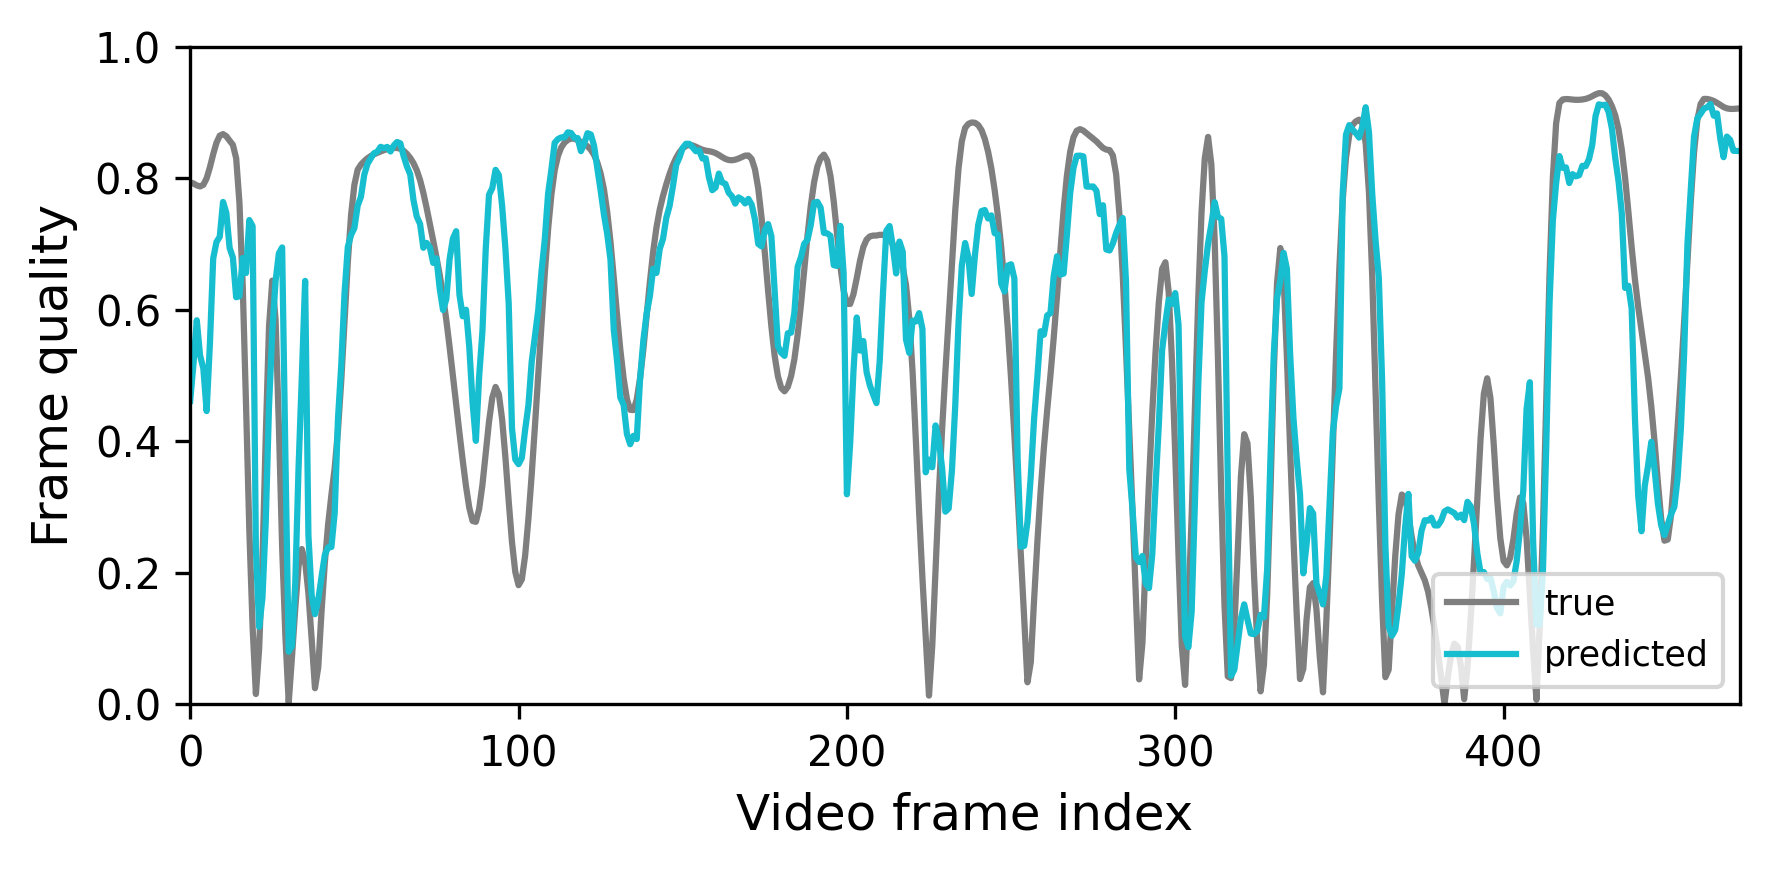

In [17]:
fig, ax = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(6, 3), dpi=300)

x = list(range(len(y)))
ax.plot(x, y, label="true", color="tab:gray")
ax.plot(x, y_hat, label="predicted", color="tab:cyan")

ax.set_xlim(left=0, right=len(y_hat))
ax.set_ylim(bottom=0, top=1)

plt.ylabel("Frame quality", size="large")
plt.xlabel("Video frame index", size="large")
ax.legend(fontsize="small", loc="lower right")

plt.show()
fig.savefig("plots/result_frame_quality_to_true_frame_quality.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(6, 3), dpi=300)

plot_best_probabilities(y_hats[0], ax)


x = list(range(len(y)))
ax.plot(x, y_hat, label="predicted", color="tab:cyan")

ax.set_xlim(left=0, right=len(y_hat))
ax.set_ylim(bottom=0, top=1)

plt.ylabel("Frame quality \\ probability".replace("_", "\n"), size="large")
plt.xlabel("Video frame index", size="large")
ax.legend(fontsize="x-small", loc="lower right")

plt.show()
fig.savefig("plots/result_frame_quality_to_probability.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, tight_layout=True, figsize=(6, 3), dpi=300)

plot_best_probabilities(y_hats[0], ax)


x = list(range(len(y)))
ax.plot(x, y, label="true", color="tab:gray")

ax.set_xlim(left=0, right=len(y))
ax.set_ylim(bottom=0, top=1)

plt.ylabel("Frame quality \\ probability".replace("_", "\n"), size="large")
plt.xlabel("Video frame index", size="large")
ax.legend(fontsize="x-small", loc="lower right")

plt.show()
fig.savefig("plots/result_true_frame_quality_to_probability.pdf", bbox_inches="tight")

In [ ]:
img_size = (165, 240)

videos = USVideosFrameDataset(
    data_dir=str(root / "data"),
    dataset_name="US_VIDEOS_tran_0500",
    train=False,
    transform=torch.nn.Sequential(
        T.Grayscale(),
        T.Resize(img_size, antialias=True),
        T.ConvertImageDtype(torch.float32),
    ),
)

min_quality = 0.3
samples = 5
beans = 10

nrows = 1
figsize = 1.5
scale = img_size[0] / img_size[1]
fig, axes = plt.subplots(
    ncols=1,
    nrows=nrows,
    squeeze=True,
    tight_layout=True,
    figsize=(figsize * samples, figsize * scale * nrows * 3),
    #     figsize=(7, 3)
    dpi=300,
)


qualities = []
true_qualities = []

rows = []
# For each label
for j in range(3):
    mask = torch.ne(preds, j)
    y_hat_label = torch.masked_fill(y_hat, mask, 0)
    # y_hat_label[:25] = 0  # omit first 25 frames
    best = torch.argsort(y_hat_label, descending=True)

    # delete frames from other classes and low quality frames
    best = [idx.item() for idx in best if y_hat_label[idx] != 0 and y_hat_label[idx] > min_quality]

    bean_size = int(len(best) / beans) + 1
    samples_ = [idx for i, idx in enumerate(best) if i % bean_size == 0][:samples]

    # for each sample
    frames = [videos[0, idx] for idx in reversed(samples_)]
    row = torch.cat(frames, dim=2)
    rows.append(row)

    qualities.extend([y_hat[idx].item() for idx in reversed(samples_)])
    true_qualities.extend([y[idx].item() for idx in reversed(samples_)])

img = torch.cat(rows, dim=1)
img = TF.to_pil_image(img)
img = TF.to_grayscale(img)
img = np.asarray(img)
axes.imshow(img, cmap="gray")
axes.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

for col_idx in range(samples):
    for label_idx in range(3):
        axes.text(
            img_size[1] * col_idx + img_size[1] - 10,
            img_size[0] * label_idx + 10,
            f"{qualities[label_idx * samples + col_idx]:.2f}",
            size="large",
            color="tab:cyan",
            bbox={"pad": 0, "color": (0, 0, 0, 0.3)},
            horizontalalignment="right",
            verticalalignment="top",
        )
        axes.text(
            img_size[1] * col_idx + img_size[1] - 10,
            img_size[0] * label_idx + 41,
            f"{true_qualities[label_idx * samples + col_idx]:.2f}",
            size="large",
            color="tab:gray",
            bbox={"pad": 0, "color": (0, 0, 0, 0.3)},
            horizontalalignment="right",
            verticalalignment="top",
        )

for label_idx in range(3):
    axes.text(
        -30,
        img_size[0] * label_idx + img_size[0] / 2,
        label_def[label_idx].replace("-", "\n"),
        rotation=90,
        horizontalalignment="center",
        verticalalignment="center",
    )


plt.xlabel("Standard Planes", size="large")

plt.show()
fig.savefig("plots/result_samples_planes.pdf", bbox_inches="tight")